In [12]:
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import scipy.io.wavfile as wavfile
import librosa as librosa
from sklearn.utils import resample

%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## ACÁ ESTÁ EL CÓDIGO QUE ARMA LA MATRIZ SHIFTEADA
def matriz_shifteada(features,delays):
    features = np.matrix(features).T
    nt,ndim = features.shape
    dstims = []
    for di,d in enumerate(delays):
        dstim = np.zeros((nt, ndim))
        if d<0: ## negative delay
            dstim[:d,:] = features[-d:,:] # The last d elements until the end
        elif d>0:
            dstim[d:,:] = features[:-d,:] # All but the last d elements
        else:
            dstim =  features.copy()
        dstims.append(dstim)
    dstims = np.hstack(dstims)
    print("Stimulus matrix is now %d time points by %d features (should be # original features \
    (%d) x # delays (%d))"%(dstims.shape[0], dstims.shape[1], features.shape[1], len(delays)))   
    return dstims

print("prueba 1: con 3 variables y 2 delays")
prueba = np.array([[1,2,3],[4,5,6],[7,8,9]])
delays = np.arange(2).astype("int")
print(matriz_shifteada(prueba,delays))
print("\n")

print("prueba 2: con 1 variables y 3 delays")
prueba = np.array([1,2,3])
delays = np.arange(3).astype("int")
print(matriz_shifteada(prueba,delays))
print("\n")

prueba 1: con 3 variables y 2 delays
Stimulus matrix is now 3 time points by 6 features (should be # original features     (3) x # delays (2))
[[1. 4. 7. 0. 0. 0.]
 [2. 5. 8. 1. 4. 7.]
 [3. 6. 9. 2. 5. 8.]]


prueba 2: con 1 variables y 3 delays
Stimulus matrix is now 3 time points by 3 features (should be # original features     (1) x # delays (3))
[[1. 0. 0.]
 [2. 1. 0.]
 [3. 2. 1.]]




## Armo el envelope

In [14]:
trials= [1,2,3,5,6,7,8,9] ## saco el 4 porque es el que está raro (por alguna razón tiene más audio que eeg)
sr = 128 # voy a dejar todo en 128
salto_envelope=125 ## esto hace que te quede con un largo igual al del wav subsampleado
largo_envelope=8000 ## esto es cuanto tiempo toma de ventana para armar el envelope
hablante = [1,2,1,1,2,1,2,1] #quien es el "Hablante" (el que le da las instrucciones) en cada trial
delay_time = 0.53

In [15]:
delays = np.arange(np.floor(delay_time*sr), dtype=np.int) 
dstims_total = np.matrix(np.zeros(len(delays)))
largo_feature = []

for i in np.arange(len(trials)):
    trial_a_tomar = trials[i]
    ubi = "Datos/wavs/S21/s21.objects.0"+str(trial_a_tomar)+".channel"+str(hablante[i])+".wav" 
    wav1 = wavfile.read(ubi)[1]
    wav1 = wav1.astype("float")
    ### envelope
    salto = salto_envelope 
    largo = largo_envelope 
    envelope = librosa.feature.rms(wav1,frame_length=largo,hop_length=salto)
    envelope = envelope.ravel().flatten()
    
    ## hasta acá ya tengo el envelope
    
    largo_feature.append(len(envelope)) ## guardo el largo del envelope que en un ratito lo voy a usar
    dstims = matriz_shifteada(envelope,delays) # armo la matriz shifteada
    
    ## luego le quito los primeros 300 ms y lo agrego a la tira de envelopes
    inicio = int(np.ceil(delay_time * sr))
    
    dstims = dstims[inicio:,:]
    dstims_total= np.concatenate([dstims_total,dstims],axis=0)
    
## le tiro la primera fila (todo 0)
dstims_total = dstims_total[1:,:]

#estandarizo
dstims_total = (dstims_total - dstims_total.mean(0))/dstims_total.std(0)
dstims = dstims_total

Stimulus matrix is now 9169 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 14933 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 18010 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 46789 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 39139 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 10722 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 10846 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 30380 time points by 67 features (should be # original features     (1) x # delays (67))


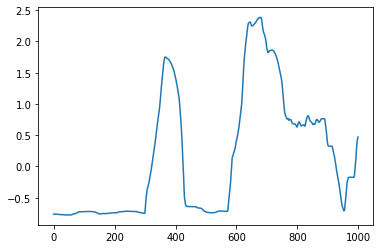

In [16]:
plt.plot(dstims[0:1000,0]) # así se ven todos los envelopes pegaditos cuando tirás los primeros 300 ms.

Ahora hay que recortar el envelope y dejar solamente aquellos momentos en los que el que seguía instrucciones está callado y escuchando audio de la otra persona.
Para eso voy a usar las transcripciones: voy a armar un vector de 1 y "nan". 
1 para los trials que quiero, "nan" para los que no. Despues multiplico por el envelope por el vector y tiro los nans. Así solamente me quedan los pedacitos de envelope que necesito. Guardo el indice de los samples que tire asi despues tiro lo mismo en el eeg.

In [20]:
dstims2_total = np.matrix(np.zeros(len(delays)))

for i in np.arange(len(trials)):
    trial_a_tomar = trials[i]
    ubi= "Datos/phrases/S21/s21.objects.0"+str(trial_a_tomar)+".channel"+str(hablante[i])+".phrases"
    h1t = pd.read_table(ubi,header=None,sep="\t")
    ## paso los numerales a vacío. Cambio texto por 1 y silencio por 0
    h1t.iloc[:,2] =(h1t.iloc[:,2].replace("#","").apply(len)>0).apply(int)
    
    ## tomo la diferencia entre el tiempo en el que empieza a hablar y el tiempo que termina de hablar
    ## lo multiplico por el sampling rate (128) y lo redondeo. Me va a quedar muy parecido al largo del envelope
    ## pero con una pequeña diferencia de una o dos samples
    veces=np.round((h1t[1] - h1t[0])*sr).astype("int")
    hablante1 = np.repeat(h1t.iloc[:,2],veces) 
    hablante1 = hablante1.ravel()
    
    ## hago lo mismo con el interlocutor
    oyente =(np.array(hablante) - 3)*-1
    ubi= "Datos/phrases/S21/s21.objects.0"+str(trial_a_tomar)+".channel"+str(oyente[i])+".phrases"
    h2t = pd.read_table(ubi,header=None,sep="\t")
    ## paso los numerales a vacío. Cambio texto por 1 y silencio por 0
    h2t.iloc[:,2] =(h2t.iloc[:,2].replace("#","").apply(len)>0).apply(int)
    veces=np.round((h2t[1] - h2t[0])*sr).astype("int")
    hablante2 = np.repeat(h2t.iloc[:,2],veces) 
    hablante2 = hablante2.ravel()
    
    ## hay diferencias de largos entre los hablantes? corrijo con 0-padding
    diferencia = len(hablante1) - len(hablante2)
    if diferencia > 0:
        hablante2 = np.concatenate([hablante2,np.repeat(0,diferencia)])
    elif diferencia <0 : 
        hablante1 = np.concatenate([hablante1,np.repeat(0,np.abs(diferencia))])
    
    ## multiplico hablante2 por 2 y los sumo así tengo un vector en el que
    ## 0 es silencio, 1 es que habla el que dirige, 2 es que habla el "oyente"
    ## 3 es que hablan los 2 a la vez.
    
    hablantes = hablante1 + hablante2*2
    
    ## corrijo las diferencias entre el largo del envelope y el largo del vectorcito este 
    diferencia = len(hablantes) - largo_feature[i]
    if diferencia < 0:
        hablante2 = np.concatenate([hablantes,np.repeat(0,diferencia)])
    elif diferencia >0 : 
        hablantes = hablantes[:-diferencia]
        
        
    #nota: las diferencias siempre son de 3 o 4 samples. 
    
    ## armo la matriz shifteada de la misma manera que con el envelope. 
    ## voy a tener una matriz de features igual a la del envelope pero con 0 en silencio
    ## 1 cuando habla el que dirige, 2 cuando habla el que escucha y 3 cuando hablan los 2.
    dstims2 = matriz_shifteada(hablantes,delays)
    inicio = int(np.ceil(delay_time * sr)) ## le tiro los primeros 300 ms
    dstims2 = dstims2[inicio:,:]
    dstims2_total= np.concatenate([dstims2_total,dstims2],axis=0)
## le tiro la primera fila (todo 0)
dstims2_total = dstims2_total[1:,:]
dstims2 = dstims2_total

Stimulus matrix is now 9169 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 14933 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 18010 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 46789 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 39139 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 10722 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 10846 time points by 67 features (should be # original features     (1) x # delays (67))
Stimulus matrix is now 30380 time points by 67 features (should be # original features     (1) x # delays (67))


In [21]:
print(dstims.shape)
print(dstims2.shape)


(179444, 67)
(179444, 67)


Lo bueno de haber hecho la matriz con 0,1,2,3 es que puedo elegir con que me quedo y que tiro. Ahora me voy a quedar solamente con los pedazos en los que el que dirige está hablando y el que lo sigue está escuchando en silencio.

In [22]:
dstims2[dstims2 != 1] = float("nan") #convierto a nan todo lo que no quiero
inds = pd.isnull(dstims2).any(1).nonzero()[0] # guardo los indices
dstims = np.delete(dstims,inds,axis=0) ## y los borro

In [23]:
dstims.shape

(48342, 67)

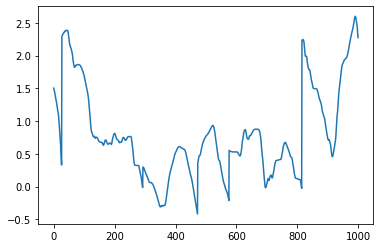

In [24]:
# queda así (comparar con el gráfico de arriba)
plt.plot(dstims[0:1000,0])

## Armo el EEG

In [25]:
#para subsamplear
def subsamplear(x,cada_cuanto):
    x = np.array(x)
    tomar = np.arange(0,len(x),int(cada_cuanto))
    return x[tomar]   

In [27]:
trial_a_tomar = trials[i]
ubi = "Datos/EEG/S21/s21-2-Trial"+str(trial_a_tomar)+"-Deci-Filter-Trim-ICA-Pruned.set"
eeg = mne.io.read_raw_eeglab(ubi)
eeg_freq = eeg.info.get("sfreq")
eeg.load_data()
eeg = eeg.filter(l_freq= None, h_freq= 40) ## hago un lowpass de 40
eeg =eeg.to_data_frame()


Reading Datos/EEG/S21/s21-2-Trial9-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 121543  =      0.000 ...   237.389 secs...


/home/joaco/anaconda3/lib/python3.7/site-packages/mne/annotations.py:366: RuntimeWarning: invalid value encountered in less
  out_of_bounds = (absolute_onset > tmax) | (absolute_offset < tmin)
/home/joaco/anaconda3/lib/python3.7/site-packages/mne/annotations.py:375: RuntimeWarning: invalid value encountered in greater
  clip_right_elem = (absolute_offset > tmax) & ~out_of_bounds
<ipython-input-27-408e1a7d5abd>:3: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-27-408e1a7d5abd>:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...


In [29]:
eeg_final = np.matrix(np.zeros(128))
largos_eeg = []
for i in np.arange(len(trials)):
    trial_a_tomar = trials[i]
    ubi = "Datos/EEG/S21/s21-2-Trial"+str(trial_a_tomar)+"-Deci-Filter-Trim-ICA-Pruned.set"
    eeg = mne.io.read_raw_eeglab(ubi)
    eeg_freq = eeg.info.get("sfreq")
    eeg.load_data()
    eeg = eeg.filter(l_freq= None, h_freq= 40) ## hago un lowpass de 40
    eeg =eeg.to_data_frame()
    eeg = np.matrix(eeg)
    eeg = eeg[:,0:128] ## tomo 128 canales

    ## emparejo con el audio
    l_feat = largo_feature[i]
    dif_en_seg = eeg.shape[0]/eeg_freq- l_feat/sr
    print("la diferencia en frames es de {}".format(dif_en_seg*eeg_freq))
    if (dif_en_seg > 0):
        tirar= int(np.ceil(dif_en_seg*eeg_freq))
        eeg = eeg[0:-tirar,:]
        print("corrijo... son iguales? " + str(eeg.shape[0]/eeg_freq == l_feat/sr))
    elif dif_en_seg <0:
        ## habia chequeado a mano que el eeg nunca es menor al audio, así que esto no debería pasar
        print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    else:
        print("no hace falta corregir? " + str(eeg.shape[0]/eeg_freq == l_feat/sr))
    ## estandarizo
    eeg = (eeg - eeg.mean(0))/eeg.std(0)

    ## subsampleo
    eeg_s = subsamplear(eeg,eeg_freq/sr)
    print("al tomar una muestra cada {} samples, hay una diferencia de {} segundos".format(eeg_freq/sr ,eeg_s.shape[0]/128- eeg.shape[0]/512))
    print("y con el audio hay una diferencia de {} segundos".format(eeg_s.shape[0] - float(l_feat)))
    eeg = eeg_s
    
    ## le tiro los primeros 300 ms
    inicio = int(np.ceil(delay_time * sr)) ## le tiro los primeros 300 ms
    eeg = eeg[inicio:]

    largos_eeg.append(eeg.shape[0])

    ## lo uno a la tira de eeg
    eeg_final = np.concatenate([eeg_final,eeg],axis=0)
    print("fin de iteracion")
    print("el largo de eeg_final es de {} samples".format(str(eeg_final.shape[0])))
    print("y el largo de dtsims es de {} sampes".format(str(dstims.shape[0])) )
    print("\n \n")
    print("##########################################################")
    print("\n \n")

## tiro el primero porque le habia puesto todo 0 para empezar

eeg = eeg_final[1:,:]

Reading Datos/EEG/S21/s21-2-Trial1-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 36680  =      0.000 ...    71.641 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 5.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 9102 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial2-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 59741  =      0.000 ...   116.682 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 10.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 23967 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial3-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 72046  =      0.000 ...   140.715 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 7.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 41909 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial5-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 187159  =      0.000 ...   365.545 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 4.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 88630 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial6-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 156569  =      0.000 ...   305.799 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 14.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 127701 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial7-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 42907  =      0.000 ...    83.803 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 20.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 138355 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial8-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 43403  =      0.000 ...    84.771 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 20.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 149133 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 

Reading Datos/EEG/S21/s21-2-Trial9-Deci-Filter-Trim-ICA-Pruned.fdt
Reading 0 ... 121543  =      0.000 ...   237.389 secs...


<ipython-input-29-22c29323b98b>:6: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  eeg = mne.io.read_raw_eeglab(ubi)
<ipython-input-29-22c29323b98b>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg = mne.io.read_raw_eeglab(ubi)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 169 samples (0.330 sec)

Converting "time" to "<class 'numpy.int64'>"...
la diferencia en frames es de 24.0
corrijo... son iguales? True
al tomar una muestra cada 4.0 samples, hay una diferencia de 0.0 segundos
y con el audio hay una diferencia de 0.0 segundos
fin de iteracion
el largo de eeg_final es de 179445 samples
y el largo de dtsims es de 48342 sampes

 

##########################################################

 



In [30]:
## ahora le tiro los mismos samples que tiré en el audio
## entonces me quedo solamente con pedazos de eeg en los que uno habla y el otro escucha calladito.
eegz = np.delete(eeg,inds,axis=0)
nt = eegz.shape[0]

In [31]:
print("el eeg: ",eegz.shape)
print("el audio:", dstims.shape)

print("en segundos son: ",dstims.shape[0]/128)
print("Aprox "+str(np.round(dstims.shape[0]/128/60,2))+" minutos")

el eeg:  (48342, 128)
el audio: (48342, 67)
en segundos son:  377.671875
Aprox 6.29 minutos


## acá podría hacerse por training y testing, con k-fold o con otra cosa. Por ahora me quedo con train y test

In [32]:
# Training indices
train_inds = np.arange(np.int(nt*0.6))

# Ridge indices
ridge_inds = np.arange(np.int(nt*0.6),np.int(nt*0.8))

# Validation indices
val_inds = np.arange(np.int(nt*0.8),nt)

print("Delayed stimulus matrix has dimensions", dstims.shape)

# Create matrices for cross validation

# Training
tStim = dstims[train_inds,:]
tResp = eeg[train_inds,:]
tResp_z = eegz[train_inds,:]

# Ridge
rStim = dstims[ridge_inds,:]
rResp = eeg[ridge_inds,:]
rResp_z = eegz[ridge_inds,:]

# Validation
vStim = dstims[val_inds,:]
vResp = eeg[val_inds,:]
vResp_z = eegz[val_inds,:]

Delayed stimulus matrix has dimensions (48342, 67)


In [17]:
#np.savetxt(X=tStim,fname="/home/mauro/Desktop/trainset_x")
#np.savetxt(X=tResp_z,fname="/home/mauro/Desktop/trainset_y")
#np.savetxt(X=rStim,fname="/home/mauro/Desktop/testset_x")
#np.savetxt(X=rResp_z,fname="/home/mauro/Desktop/testset_y")

In [33]:
alphas = np.hstack([0,np.logspace(-4,8,13)])
correlaciones = []
pesos = []
intercepts = []
lista_Rmse = []
corrmin = 0.1

for alfa in alphas:
    mod = linear_model.Ridge(alpha=alfa, random_state=123)
    mod.fit(tStim,tResp_z) ## entreno el modelo
    predicho = mod.predict(rStim) ## testeo en ridge set
    Rcorr = np.array([np.corrcoef(rResp_z[:,ii].ravel(), np.array(predicho[:,ii]).ravel())[0,1] for ii in range(rResp_z.shape[1])])
    Rmse = np.matrix(np.sqrt(np.power((predicho - rResp_z),2).mean(0)))
    lista_Rmse.append(np.array(Rmse)[0])
    Rcorr[np.isnan(Rcorr)] = 0
    correlaciones.append(Rcorr)
    pesos.append(mod.coef_)
    intercepts.append(mod.intercept_)
    print("Training: alpha=%0.3f, mean corr=%0.3f, max corr=%0.3f, over-under(%0.2f)=%d"%(alfa, np.mean(Rcorr), np.max(Rcorr), corrmin, (Rcorr>corrmin).sum()-( -Rcorr>corrmin).sum()))
correlaciones = np.array(correlaciones)
lista_Rmse = np.array(lista_Rmse)

Training: alpha=0.000, mean corr=0.050, max corr=0.190, over-under(0.10)=13
Training: alpha=0.000, mean corr=0.050, max corr=0.190, over-under(0.10)=13
Training: alpha=0.001, mean corr=0.050, max corr=0.190, over-under(0.10)=13
Training: alpha=0.010, mean corr=0.050, max corr=0.191, over-under(0.10)=13
Training: alpha=0.100, mean corr=0.050, max corr=0.191, over-under(0.10)=13
Training: alpha=1.000, mean corr=0.051, max corr=0.191, over-under(0.10)=13
Training: alpha=10.000, mean corr=0.051, max corr=0.190, over-under(0.10)=14
Training: alpha=100.000, mean corr=0.052, max corr=0.191, over-under(0.10)=14
Training: alpha=1000.000, mean corr=0.055, max corr=0.195, over-under(0.10)=14
Training: alpha=10000.000, mean corr=0.060, max corr=0.202, over-under(0.10)=18
Training: alpha=100000.000, mean corr=0.062, max corr=0.206, over-under(0.10)=19
Training: alpha=1000000.000, mean corr=0.055, max corr=0.206, over-under(0.10)=20
Training: alpha=10000000.000, mean corr=0.050, max corr=0.206, over

# con el criterio de liberty (podria usar otro):

Text(0.5, 0.98, 'El mejor alfa es de: 100000.0')

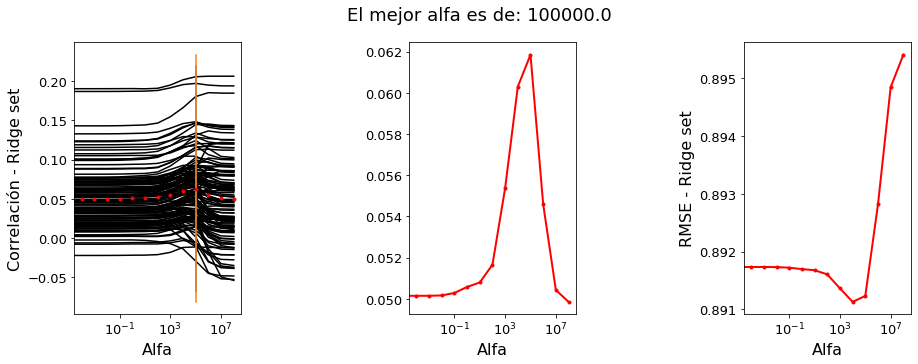

In [34]:
best_alpha_overall = correlaciones.mean(1).argmax()
best_alpha_overall = alphas[best_alpha_overall]    
# Plot correlations vs. alpha regularization value
## cada linea es un canal
fig=plt.figure(figsize=(15,5))
fig.clf()
plt.subplot(1,3,1)
plt.subplots_adjust(wspace = 1  )
plt.plot(alphas,correlaciones,'k')
plt.gca().set_xscale('log')
## en rojo: el maximo de las correlaciones
## la linea azul marca el mejor alfa

plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])
plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])


plt.plot(alphas,correlaciones.mean(1),'.r',linewidth=5)
plt.xlabel('Alfa', fontsize=16)
plt.ylabel('Correlación - Ridge set', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)

### como se ve sola la correlacion maxima para los distintos alfas
plt.subplot(1,3,2)
plt.plot(alphas,np.array(correlaciones).mean(1),'.r',linewidth=5)     
plt.plot(alphas,np.array(correlaciones).mean(1),'-r',linewidth=2)     

plt.xlabel('Alfa', fontsize=16)
plt.gca().set_xscale('log')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)
### el RMSE
plt.subplot(1,3,3)
plt.plot(alphas,np.array(lista_Rmse).min(1),'.r',linewidth=5) 
plt.plot(alphas,np.array(lista_Rmse).min(1),'-r',linewidth=2) 
plt.xlabel('Alfa', fontsize=16)
plt.ylabel('RMSE - Ridge set', fontsize=16)
plt.gca().set_xscale('log')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)

titulo = "El mejor alfa es de: "+ str(best_alpha_overall)
plt.suptitle(titulo, fontsize=18)

## Refino la búsqueda

In [35]:
min_busqueda,max_busqueda = log10(best_alpha_overall)-1,log10(best_alpha_overall)+1

In [36]:
### en ningun caso dan todos redondos

alfas = np.logspace(min_busqueda,max_busqueda,10)

for i in np.arange(10,50000):
    alfas = np.logspace(min_busqueda,max_busqueda,i)
    if np.alltrue((alfas % 10 == 0).astype("bool")):
        print(i)

In [37]:
alphas = np.logspace(min_busqueda,max_busqueda,50)
correlaciones = []
pesos = []
intercepts = []
lista_Rmse = []
corrmin = 0.1

for alfa in alphas:
    mod = linear_model.Ridge(alpha=alfa, random_state=123)
    mod.fit(tStim,tResp_z) ## entreno el modelo
    predicho = mod.predict(rStim) ## testeo en ridge set
    Rcorr = np.array([np.corrcoef(rResp_z[:,ii].ravel(), np.array(predicho[:,ii]).ravel())[0,1] for ii in range(rResp_z.shape[1])])
    Rmse = np.matrix(np.sqrt(np.power((predicho - rResp_z),2).mean(0)))
    lista_Rmse.append(np.array(Rmse)[0])
    Rcorr[np.isnan(Rcorr)] = 0
    correlaciones.append(Rcorr)
    pesos.append(mod.coef_)
    intercepts.append(mod.intercept_)
    print("Training: alpha=%0.3f, mean corr=%0.3f, max corr=%0.3f, over-under(%0.2f)=%d"%(alfa, np.mean(Rcorr), np.max(Rcorr), corrmin, (Rcorr>corrmin).sum()-( -Rcorr>corrmin).sum()))
correlaciones = np.array(correlaciones)
lista_Rmse = np.array(lista_Rmse)

Training: alpha=10000.000, mean corr=0.060, max corr=0.202, over-under(0.10)=18
Training: alpha=10985.411, mean corr=0.060, max corr=0.202, over-under(0.10)=18
Training: alpha=12067.926, mean corr=0.061, max corr=0.202, over-under(0.10)=18
Training: alpha=13257.114, mean corr=0.061, max corr=0.203, over-under(0.10)=18
Training: alpha=14563.485, mean corr=0.061, max corr=0.203, over-under(0.10)=18
Training: alpha=15998.587, mean corr=0.061, max corr=0.203, over-under(0.10)=18
Training: alpha=17575.106, mean corr=0.061, max corr=0.203, over-under(0.10)=18
Training: alpha=19306.977, mean corr=0.061, max corr=0.203, over-under(0.10)=18
Training: alpha=21209.509, mean corr=0.061, max corr=0.204, over-under(0.10)=18
Training: alpha=23299.518, mean corr=0.062, max corr=0.204, over-under(0.10)=18
Training: alpha=25595.479, mean corr=0.062, max corr=0.204, over-under(0.10)=18
Training: alpha=28117.687, mean corr=0.062, max corr=0.204, over-under(0.10)=18
Training: alpha=30888.436, mean corr=0.0

In [38]:
correlaciones.mean(1).mean()

0.06009648315380717

El mejor alfa es de:  59636.23316594637
Con una correlación media de:  0.06029612126966836
Y una correlación máxima de:  0.2018866359337977


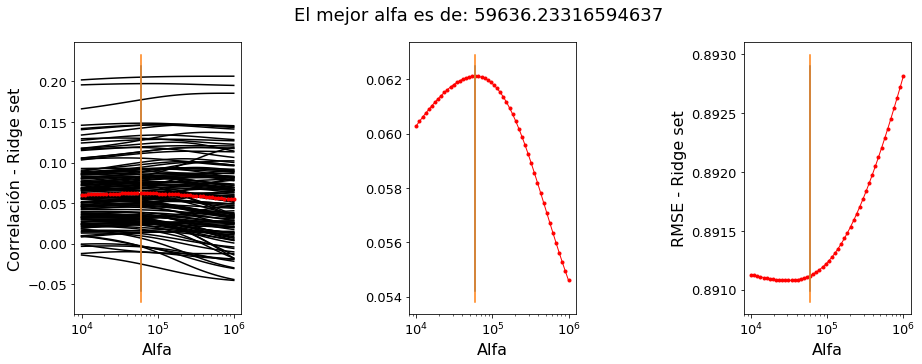

In [39]:
best_alpha_overall = correlaciones.mean(1).argmax()
best_alpha_overall = alphas[best_alpha_overall]    
# Plot correlations vs. alpha regularization value
## cada linea es un canal
fig=plt.figure(figsize=(15,5))
fig.clf()
plt.subplot(1,3,1)
plt.subplots_adjust(wspace = 1  )
plt.plot(alphas,correlaciones,'k')
plt.gca().set_xscale('log')
## en rojo: el maximo de las correlaciones
## la linea azul marca el mejor alfa

plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])
plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])


plt.plot(alphas,correlaciones.mean(1),'.r',linewidth=5)


plt.xlabel('Alfa', fontsize=16)
plt.ylabel('Correlación - Ridge set', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)

### como se ve sola la correlacion maxima para los distintos alfas
plt.subplot(1,3,2)
plt.plot(alphas,np.array(correlaciones).mean(1),'.r',linewidth=5)     
plt.plot(alphas,np.array(correlaciones).mean(1),'-r',linewidth=1)     


plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])
plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])

plt.xlabel('Alfa', fontsize=16)
plt.gca().set_xscale('log')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)
### el RMSE
plt.subplot(1,3,3)
plt.plot(alphas,np.array(lista_Rmse).min(1),'.r',linewidth=5) 
plt.plot(alphas,np.array(lista_Rmse).min(1),'-r',linewidth=1) 


plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])
plt.plot([best_alpha_overall, best_alpha_overall],[plt.ylim()[0],plt.ylim()[1]])

plt.xlabel('Alfa', fontsize=16)
plt.ylabel('RMSE - Ridge set', fontsize=16)
plt.gca().set_xscale('log')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.tick_params(axis='both', which='minor', labelsize=13)

titulo = "El mejor alfa es de: "+ str(best_alpha_overall)
plt.suptitle(titulo, fontsize=18)



print("El mejor alfa es de: ",best_alpha_overall)
print("Con una correlación media de: ",correlaciones[best_alpha_overall.argmax()].mean())
print("Y una correlación máxima de: ",correlaciones[best_alpha_overall.argmax()].max())

In [40]:
mejor_alfa = 494.17

In [41]:
mejor_alfa = best_alpha_overall

In [42]:
mod = linear_model.Ridge(alpha=mejor_alfa, random_state=123)
mod.fit(tStim,tResp_z) ## entreno el modelo
mejor_canal = correlaciones[best_alpha_overall.argmax()].argmax()

In [43]:
predicho = mod.predict(rStim) ## testeo en ridge set
Rcorr = np.array([np.corrcoef(rResp_z[:,ii].ravel(), np.array(predicho[:,ii]).ravel())[0,1] for ii in range(rResp_z.shape[1])])

In [44]:
Rcorr[29]

0.2052684059541175

In [45]:
mejor_canal

29

###  prueba

Text(0.5, 0.98, 'Betas para delay time = 0.53')

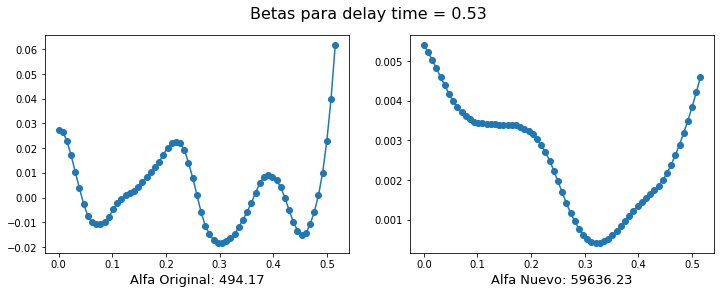

In [46]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(np.arange(0,1.0/128 * mod.coef_.shape[1],1.0/128),mod.coef_[29],"-o")
plt.xlabel("Alfa Nuevo: " +str(round(best_alpha_overall,2)) ,fontsize=13)
mejor_alfa = 494.17
mod = linear_model.Ridge(alpha=mejor_alfa, random_state=123)
mod.fit(tStim,tResp_z) ## entreno el modelo
plt.subplot(1,2,1)
plt.plot(np.arange(0,1.0/128 * mod.coef_.shape[1],1.0/128),mod.coef_[29],"-o")
plt.xlabel("Alfa Original: 494.17",fontsize=13)
plt.suptitle("Betas para delay time = "+str(delay_time),fontsize=16)

In [47]:
sujeto  = "21"

In [53]:
mejor_alfa = 494.17
mod = linear_model.Ridge(alpha=mejor_alfa, random_state=123)
mod.fit(tStim,tResp_z) ## entreno el modelo

predicho = mod.predict(rStim) ## testeo en ridge set
Rcorr_494 = np.array([np.corrcoef(rResp_z[:,ii].ravel(), np.array(predicho[:,ii]).ravel())[0,1] for ii in range(rResp_z.shape[1])])

mod.coef_.shape
Rcorr_494.shape
np.savetxt(X=mod.coef_,fname="saves/Otras Pruebas/todos los sujetos/s"+sujeto+"betas_494.txt")
np.savetxt(X=Rcorr_494,fname="saves/Otras Pruebas/todos los sujetos/s"+sujeto+"correlaciones_494.txt")

In [54]:
mejor_alfa = best_alpha_overall
mod = linear_model.Ridge(alpha=mejor_alfa, random_state=123)
mod.fit(tStim,tResp_z) ## entreno el modelo

predicho = mod.predict(rStim) ## testeo en ridge set
Rcorr_494 = np.array([np.corrcoef(rResp_z[:,ii].ravel(), np.array(predicho[:,ii]).ravel())[0,1] for ii in range(rResp_z.shape[1])])

mod.coef_.shape
Rcorr_494.shape

(128,)